<a href="https://colab.research.google.com/gist/keyboardAnt/322c4263f231387cad089ed15b0394db/lm_format_enforcer_vllm_integration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LM Format Enforcer Integration with vLLM

<a target="_blank" href="https://colab.research.google.com/github/noamgat/lm-format-enforcer/blob/main/samples/colab_vllm_integration.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

This notebook shows how you can integrate with the vLLM library. vLLM does not currently have an API for token filtering, so we have to do some monkey patching to expose the functionality.

## Setting up the COLAB runtime (user action required)

This colab-friendly notebook is targeted at demoing the enforcer on LLAMA2. It can run on a free GPU on Google Colab.
Make sure that your runtime is set to GPU:

Menu Bar -> Runtime -> Change runtime type -> T4 GPU (at the time of writing this notebook). [Guide here](https://www.codesansar.com/deep-learning/using-free-gpu-tpu-google-colab.htm).

## Gathering huggingface credentials (user action required)

We begin by installing the dependencies. This demo uses llama2, so you will have to create a free huggingface account, request access to the llama2 model, create an access token, and insert it when executing the next cell will request it.

Links:

- [Request access to llama model](https://huggingface.co/meta-llama/Llama-2-7b-chat-hf). See the "Access Llama 2 on Hugging Face" section.
- [Create huggingface access token](https://huggingface.co/settings/tokens)


In [ ]:
!pip install vllm lm-format-enforcer
!huggingface-cli login

# When running from source / developing the library, use this instead
# %load_ext autoreload
# %autoreload 2
# import sys
# import os
# sys.path.append(os.path.abspath('..'))
## os.environ['CUDA_LAUNCH_BLOCKING'] = '1'


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|
    
    A token is already saved on your machine. Run `huggingface-cli whoami` to get more information or `huggingface-cli logout` if you want to log out.
    Setting a new token will erase the existing one.
    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
Add token as git credential? (Y/n) 
Token is valid (permission: read).
Cannot authenticate through git-cre

## Creating a custom sampler that filters tokens

We introduce a subclass of vLLM's ```SamplingParams``` that also accepts a token filtering function, with the same API as Huggingface Transformers

```prefix_allowed_tokens_fn: Callable[[int, torch.Tensor], List[int]]```

We then introduce the function ```_apply_allowed_token_filters()``` that applies the filter functions to the logits (sets them to negative infinity if not allowed) to requests that contain a filter function.

We hope that in future releases of vLLM, this (or similar) will be part of vLLM's ```Sampler``` class.

In [ ]:
import vllm
import torch
from typing import List, Callable, Optional
from vllm.sampling_params import SamplingParams
from vllm.model_executor.input_metadata import InputMetadata

class SamplingParamsWithFilterFunction(SamplingParams):
    logits_allowed_tokens_filter_function: Optional[Callable[[int, torch.Tensor], List[int]]]

def _apply_allowed_token_filters(logits: torch.Tensor,
                                 input_metadata: InputMetadata) -> torch.Tensor:
    num_seqs, vocab_size = logits.shape
    logits_row_idx = 0
    for seq_ids, sampling_params in input_metadata.seq_groups:
        if isinstance(sampling_params, SamplingParamsWithFilterFunction):
            filter_function = sampling_params.logits_allowed_tokens_filter_function
        else:
            filter_function = None
        for seq_id in seq_ids:
            if filter_function is not None:
                output_token_ids = input_metadata.seq_data[seq_id].output_token_ids
                output_token_tensor = torch.tensor(output_token_ids, dtype=torch.long)
                allowed_tokens = filter_function(logits_row_idx, output_token_tensor)
                logits_add_factor = torch.zeros(vocab_size, dtype=logits.dtype, device=logits.device)
                logits_add_factor[:] = float('-inf')
                logits_add_factor[allowed_tokens] = 0
                logits[logits_row_idx] += logits_add_factor
            logits_row_idx += 1
    assert logits_row_idx == num_seqs
    return logits



In order to integrate this function with the ```Sampler``` class, we have to change its ```forward()``` function to call it. Since we are not modifying vLLM itself, we will do this with monkey patching.

Other than the line
```
logits = _apply_allowed_token_filters(logits, input_metadata)
```
this is a 100% copy of the original ```Sampler.forward()``` function.

In [ ]:
from vllm.model_executor.layers.sampler import SamplerOutput, _prune_hidden_states, _get_logits, _get_output_tokens, _get_penalties, _apply_penalties, _get_temperatures, _get_top_p_top_k, _apply_top_p_top_k, _sample, _get_logprobs, _build_sampler_output, _SAMPLING_EPS

from typing import Optional

def patched_forward(
        self,
        embedding: torch.Tensor,
        hidden_states: torch.Tensor,
        input_metadata: InputMetadata,
        embedding_bias: Optional[torch.Tensor] = None,
    ) -> SamplerOutput:
        # Get the hidden states that we use for sampling.
        hidden_states = _prune_hidden_states(hidden_states, input_metadata)

        # Get the logits for the next tokens.
        logits = _get_logits(hidden_states, embedding, embedding_bias,
                             self.vocab_size)

        # Apply presence and frequency penalties.
        output_tokens = _get_output_tokens(input_metadata)
        assert len(output_tokens) == logits.shape[0]
        presence_penalties, frequency_penalties = _get_penalties(
            input_metadata)
        assert len(presence_penalties) == logits.shape[0]
        assert len(frequency_penalties) == logits.shape[0]
        logits = _apply_penalties(logits, output_tokens, presence_penalties,
                                  frequency_penalties)

        ### LM FORMAT ENFORCER MONKEY PATCH START
        logits = _apply_allowed_token_filters(logits, input_metadata)
        ### LM FORMAT ENFORCER MONKEY PATCH END

        # Apply temperature scaling.
        temperatures = _get_temperatures(input_metadata)
        assert len(temperatures) == logits.shape[0]
        if any(t != 1.0 for t in temperatures):
            t = torch.tensor(temperatures,
                             dtype=logits.dtype,
                             device=logits.device)
            # Use in-place division to avoid creating a new tensor.
            logits.div_(t.unsqueeze(dim=1))

        # Apply top-p and top-k truncation.
        top_ps, top_ks = _get_top_p_top_k(input_metadata, self.vocab_size)
        assert len(top_ps) == len(top_ks) == logits.shape[0]
        do_top_p = any(p < 1.0 - _SAMPLING_EPS for p in top_ps)
        do_top_k = any(k != self.vocab_size for k in top_ks)
        if do_top_p or do_top_k:
            logits = _apply_top_p_top_k(logits, top_ps, top_ks)

        # We use float32 for probabilities and log probabilities.
        # Compute the probabilities.
        probs = torch.softmax(logits, dim=-1, dtype=torch.float)
        # Compute the log probabilities.
        # Use log_softmax to ensure numerical stability.
        logprobs = torch.log_softmax(logits, dim=-1, dtype=torch.float)

        # Sample the next tokens.
        sample_results = _sample(probs, logprobs, input_metadata)
        # Get the logprobs query results.
        prompt_logprobs, sample_logprobs = _get_logprobs(
            logprobs, input_metadata, sample_results)
        return _build_sampler_output(sample_results, input_metadata,
                                     prompt_logprobs, sample_logprobs)

We load the model, as is normally done with vLLM

In [ ]:
# model_id = 'meta-llama/Llama-2-7b-chat-hf'
# model_id = 'facebook/opt-125m'
model_id = "NousResearch/Llama-2-7b-chat-hf"
llm = vllm.LLM(model=model_id)

INFO 10-31 15:50:34 llm_engine.py:72] Initializing an LLM engine with config: model='NousResearch/Llama-2-7b-chat-hf', tokenizer='NousResearch/Llama-2-7b-chat-hf', tokenizer_mode=auto, revision=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.float16, max_seq_len=4096, download_dir=None, load_format=auto, tensor_parallel_size=1, quantization=None, seed=0)
INFO 10-31 15:50:34 tokenizer.py:31] For some LLaMA V1 models, initializing the fast tokenizer may take a long time. To reduce the initialization time, consider using 'hf-internal-testing/llama-tokenizer' instead of the original tokenizer.
INFO 10-31 15:51:52 llm_engine.py:207] # GPU blocks: 26, # CPU blocks: 512


If the previous cell executed successfully, you have propertly set up your Colab runtime and huggingface account!

A few helper functions to make display nicer.

In [ ]:
from IPython.display import display, Markdown

def display_header(text):
    display(Markdown(f'**{text}**'))

def display_content(text):
    display(Markdown(f'```\n{text}\n```'))

## Setting up the prompt for the specific language model

We set up the prompting style according to the [Llama2 demo](https://huggingface.co/spaces/huggingface-projects/llama-2-13b-chat/blob/main/app.py). We simplify the implementation a bit as we don't need chat history for this demo.

In [ ]:
DEFAULT_SYSTEM_PROMPT = """\
You are a helpful, respectful and honest assistant. Always answer as helpfully as possible, while being safe.  Your answers should not include any harmful, unethical, racist, sexist, toxic, dangerous, or illegal content. Please ensure that your responses are socially unbiased and positive in nature.\n\nIf a question does not make any sense, or is not factually coherent, explain why instead of answering something not correct. If you don't know the answer to a question, please don't share false information.\
"""

def get_prompt(message: str, system_prompt: str = DEFAULT_SYSTEM_PROMPT) -> str:
    return f'<s>[INST] <<SYS>>\n{system_prompt}\n<</SYS>>\n\n{message} [/INST]'

## Activating the monkey patch and creating the generation function

We monkey-patch the ```Sampler``` class with our custom ```forward()``` method, using ```unittest.mock```.

We use our sampling params in order to sent the specific filter function with the request. Different requests can have different format enforcers.

In [ ]:
from lmformatenforcer import CharacterLevelParser
from lmformatenforcer.integrations.transformers import build_transformers_prefix_allowed_tokens_fn
from unittest import mock

DEFAULT_MAX_NEW_TOKENS = 100

def vllm_with_character_level_parser(llm: vllm.LLM, prompt: str, parser: Optional[CharacterLevelParser] = None) -> str:
    with mock.patch.object(vllm.model_executor.layers.sampler.Sampler, 'forward', patched_forward):
        prefix_function = build_transformers_prefix_allowed_tokens_fn(llm.get_tokenizer(), parser) if parser else None
        sampling_params = SamplingParamsWithFilterFunction()
        sampling_params.max_tokens = DEFAULT_MAX_NEW_TOKENS
        sampling_params.logits_allowed_tokens_filter_function = prefix_function
        result = llm.generate(prompt, sampling_params=sampling_params)
        return result[0].outputs[0].text

## vLLM + JSON Use case

Now we demonstrate using ```JsonSchemaParser```. We create a pydantic model, generate the schema from it, and use that to enforce the format.
The output will always be in a format that can be parsed by the parser.

In [ ]:
from lmformatenforcer import JsonSchemaParser
from pydantic import BaseModel

from typing import List

class AnswerFormat(BaseModel):
    first_name: str
    last_name: str
    year_of_birth: int
    num_seasons_in_nba: int

question = 'Please give me information about Michael Jordan. You MUST answer using the following json schema: '
question_with_schema = f'{question}{AnswerFormat.schema_json()}'
prompt = get_prompt(question_with_schema)

display_header("Prompt:")
display_content(prompt)

display_header("Answer, With json schema enforcing:")

result = vllm_with_character_level_parser(llm, prompt, JsonSchemaParser(AnswerFormat.schema()))
display_content(result)

display_header("Answer, Without json schema enforcing:")
result = vllm_with_character_level_parser(llm, prompt, None)
display_content(result)



**Prompt:**

```
<s>[INST] <<SYS>>
You are a helpful, respectful and honest assistant. Always answer as helpfully as possible, while being safe.  Your answers should not include any harmful, unethical, racist, sexist, toxic, dangerous, or illegal content. Please ensure that your responses are socially unbiased and positive in nature.

If a question does not make any sense, or is not factually coherent, explain why instead of answering something not correct. If you don't know the answer to a question, please don't share false information.
<</SYS>>

Please give me information about Michael Jordan. You MUST answer using the following json schema: {"title": "AnswerFormat", "type": "object", "properties": {"first_name": {"title": "First Name", "type": "string"}, "last_name": {"title": "Last Name", "type": "string"}, "year_of_birth": {"title": "Year Of Birth", "type": "integer"}, "num_seasons_in_nba": {"title": "Num Seasons In Nba", "type": "integer"}}, "required": ["first_name", "last_name", "year_of_birth", "num_seasons_in_nba"]} [/INST]
```

**Answer, With json schema enforcing:**

Processed prompts: 100%|██████████| 1/1 [00:06<00:00,  6.24s/it]


```
  {
"first_name": "Michael",
"last_name": "Jordan",
"year_of_birth": 1963,
"num_seasons_in_nba": 15
}
```

**Answer, Without json schema enforcing:**

Processed prompts: 100%|██████████| 1/1 [00:06<00:00,  6.25s/it]


```
  Of course! Here's the requested information about Michael Jordan in the format specified:

{
"title": "AnswerFormat",
"type": "object",
"properties": {
"first_name": {
"title": "First Name",
"type": "string",
"example": "Michael"
},
"last_name": {
"title": "Last Name",
"type": "string",
"example": "J
```

As you can see, the enforced output matches the required schema, while the unenforced does not. We have successfully integrated with vLLM!

In [ ]:
def batch_vllm_with_character_level_parser(llm: vllm.LLM, prompts: list[str], parser: Optional[CharacterLevelParser] = None) -> list[str]:
    with mock.patch.object(vllm.model_executor.layers.sampler.Sampler, 'forward', patched_forward):
        prefix_function = build_transformers_prefix_allowed_tokens_fn(llm.get_tokenizer(), parser) if parser else None
        sampling_params = SamplingParamsWithFilterFunction()
        sampling_params.max_tokens = DEFAULT_MAX_NEW_TOKENS
        sampling_params.logits_allowed_tokens_filter_function = prefix_function
        results = llm.generate(prompts, sampling_params=sampling_params)
        return [r.outputs[0].text for r in results]

In [ ]:
def get_prompts(names, AnswerFormat):
  return [f"Please give me information about {name}. You MUST answer using the following json schema:\n{AnswerFormat.schema_json()}" for name in names]


names = \
 ['Michael Jordan',
 'Babe Ruth',
 'Muhammad Ali',
 'Jim Brown',
 'Wayne Gretzky',
 'Jesse Owens',
 'Jim Thorpe',
 'Willie Mays',
 'Jack Nicklaus',
 'Babe Didrikson',
 'Joe Louis',
 'Carl Lewis',
 'Wilt Chamberlain',
 'Hank Aaron',
 'Jackie Robinson',
 'Ted Williams',
 'Magic Johnson',
 'Bill Russell',
 'Martina Navratilova',
 'Ty Cobb',
 'Gordie Howe',
 'Joe DiMaggio',
 'Jackie Joyner-Kersee',
 'Sugar Ray Robinson',
 'Joe Montana',
 'Kareem Abdul-Jabbar',
 'Jerry Rice',
 'Red Grange',
 'Arnold Palmer',
 'Larry Bird',
 'Bobby Orr',
 'Johnny Unitas',
 'Mark Spitz',
 'Lou Gehrig',
 'Secretariat',
 'Oscar Robertson',
 'Mickey Mantle',
 'Ben Hogan',
 'Walter Payton',
 'Lawrence Taylor',
 'Wilma Rudolph',
 'Sandy Koufax',
 'Julius Erving',
 'Bobby Jones',
 'Bill Tilden',
 'Eric Heiden',
 'Edwin Moses',
 'Pete Sampras',
 'O.J. Simpson',
 'Chris Evert',
 'Rocky Marciano',
 'Jack Dempsey',
 'Rafer Johnson',
 'Greg Louganis',
 'Mario Lemieux',
 'Pete Rose',
 'Willie Shoemaker',
 'Elgin Baylor',
 'Billie Jean King',
 'Walter Johnson',
 'Stan Musial',
 'Jerry West',
 'Satchel Paige',
 'Sammy Baugh',
 'Althea Gibson',
 'Eddie Arcaro',
 'Bob Gibson',
 'Al Oerter',
 'Bonnie Blair',
 'Dick Butkus',
 'Roberto Clemente',
 'Bo Jackson',
 'Josh Gibson',
 'Deion Sanders',
 'Dan Marino',
 'Barry Sanders',
 'Cy Young',
 'Bob Mathias',
 'Gale Sayers',
 'A.J. Foyt',
 'Jimmy Connors',
 'Bobby Hull',
 'Honus Wagner',
 "Man o' War",
 'Maurice Richard',
 'Otto Graham',
 'Henry Armstrong',
 'Joe Namath',
 'Rogers Hornsby',
 'Richard Petty',
 'Bob Beamon',
 'Mario Andretti',
 'Don Hutson',
 'Bob Cousy',
 'George Blanda',
 'Michael Johnson',
 'Citation',
 'Don Budge',
 'Sam Snead',
 'Jack Johnson']


def get_players(num_of_names: int) -> list[AnswerFormat | ValueError]:
  prompts = get_prompts(names[:num_of_names], AnswerFormat)
  players_raw = batch_vllm_with_character_level_parser(llm, prompts, JsonSchemaParser(AnswerFormat.schema()))
  players = []
  for p in players_raw:
    try:
      players.append(AnswerFormat.parse_raw(p))
    except ValueError as e:
      players.append(e)
  print()
  print("The number of parsed players: ", sum([isinstance(p, AnswerFormat) for p in players]))
  return players

In [ ]:
players = get_players(3)
players

Processed prompts: 100%|██████████| 3/3 [00:13<00:00,  4.57s/it]


The number of parsed players:  3


[AnswerFormat(first_name='Michael', last_name='Jordan', year_of_birth=1963, num_seasons_in_nba=15),
 AnswerFormat(first_name='George', last_name='Herman', year_of_birth=1895, num_seasons_in_nba=20),
 AnswerFormat(first_name='Muhammad', last_name='Ali', year_of_birth=1942, num_seasons_in_nba=56)]

In [ ]:
%%timeit

get_players(1)

Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.42s/it]



The number of parsed players:  1


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.68s/it]



The number of parsed players:  1


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.49s/it]



The number of parsed players:  1


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.53s/it]



The number of parsed players:  1


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.87s/it]



The number of parsed players:  1


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.48s/it]



The number of parsed players:  1


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.39s/it]



The number of parsed players:  1


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.75s/it]


The number of parsed players:  1
5.72 s ± 575 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
%%timeit

get_players(10)

Processed prompts: 100%|██████████| 10/10 [00:45<00:00,  4.59s/it]



The number of parsed players:  10


Processed prompts: 100%|██████████| 10/10 [00:40<00:00,  4.05s/it]



The number of parsed players:  10


Processed prompts: 100%|██████████| 10/10 [00:42<00:00,  4.25s/it]



The number of parsed players:  10


Processed prompts: 100%|██████████| 10/10 [00:41<00:00,  4.18s/it]



The number of parsed players:  10


Processed prompts: 100%|██████████| 10/10 [00:39<00:00,  3.95s/it]



The number of parsed players:  10


Processed prompts: 100%|██████████| 10/10 [00:44<00:00,  4.41s/it]



The number of parsed players:  10


Processed prompts: 100%|██████████| 10/10 [00:43<00:00,  4.35s/it]



The number of parsed players:  10


Processed prompts: 100%|██████████| 10/10 [00:41<00:00,  4.16s/it]



The number of parsed players:  10
43.1 s ± 1.69 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
%%timeit

get_players(32)

Processed prompts: 100%|██████████| 32/32 [02:17<00:00,  4.29s/it]



The number of parsed players:  32


Processed prompts: 100%|██████████| 32/32 [02:18<00:00,  4.32s/it]



The number of parsed players:  32


Processed prompts: 100%|██████████| 32/32 [02:14<00:00,  4.20s/it]



The number of parsed players:  32


Processed prompts: 100%|██████████| 32/32 [02:11<00:00,  4.11s/it]



The number of parsed players:  32


Processed prompts: 100%|██████████| 32/32 [02:18<00:00,  4.32s/it]



The number of parsed players:  32


Processed prompts: 100%|██████████| 32/32 [02:18<00:00,  4.34s/it]



The number of parsed players:  31


Processed prompts: 100%|██████████| 32/32 [02:17<00:00,  4.29s/it]



The number of parsed players:  32


Processed prompts: 100%|██████████| 32/32 [02:14<00:00,  4.20s/it]



The number of parsed players:  32
2min 17s ± 2.54 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
%%timeit

get_players(64)

Processed prompts: 100%|██████████| 64/64 [04:43<00:00,  4.43s/it]



The number of parsed players:  64


Processed prompts: 100%|██████████| 64/64 [04:47<00:00,  4.49s/it]



The number of parsed players:  64


Processed prompts: 100%|██████████| 64/64 [04:40<00:00,  4.38s/it]



The number of parsed players:  64


Processed prompts: 100%|██████████| 64/64 [04:35<00:00,  4.30s/it]



The number of parsed players:  64


Processed prompts: 100%|██████████| 64/64 [04:39<00:00,  4.36s/it]



The number of parsed players:  64


Processed prompts: 100%|██████████| 64/64 [04:28<00:00,  4.19s/it]



The number of parsed players:  64


Processed prompts: 100%|██████████| 64/64 [04:32<00:00,  4.25s/it]



The number of parsed players:  64


Processed prompts: 100%|██████████| 64/64 [04:35<00:00,  4.30s/it]



The number of parsed players:  64
4min 38s ± 5.9 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
%%timeit

get_players(100)

Processed prompts: 100%|██████████| 100/100 [07:04<00:00,  4.25s/it]



The number of parsed players:  99


Processed prompts: 100%|██████████| 100/100 [06:52<00:00,  4.13s/it]



The number of parsed players:  100


Processed prompts: 100%|██████████| 100/100 [07:18<00:00,  4.38s/it]



The number of parsed players:  100


Processed prompts: 100%|██████████| 100/100 [07:17<00:00,  4.38s/it]



The number of parsed players:  100


Processed prompts: 100%|██████████| 100/100 [07:14<00:00,  4.34s/it]



The number of parsed players:  100


Processed prompts: 100%|██████████| 100/100 [07:21<00:00,  4.42s/it]



The number of parsed players:  100


Processed prompts: 100%|██████████| 100/100 [07:05<00:00,  4.25s/it]



The number of parsed players:  100


Processed prompts: 100%|██████████| 100/100 [06:58<00:00,  4.19s/it]



The number of parsed players:  100
7min 11s ± 9.99 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


<ErrorbarContainer object of 3 artists>

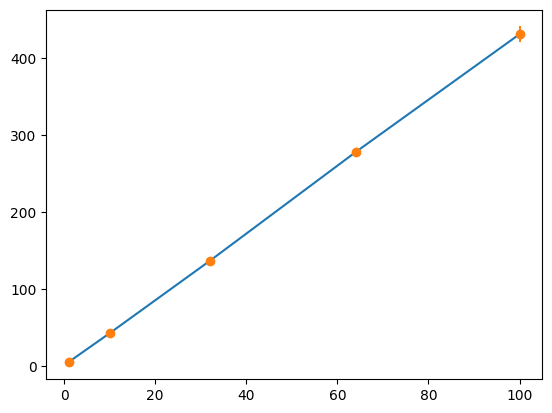

In [ ]:
import matplotlib.pyplot as plt


x = [1, 10, 32, 64, 100]
y = [5.72, 43.1, 137, 278, 431]
yerr = [.575, 1.69, 2.54, 5.9, 9.99]

plt.plot(x, y)
plt.errorbar(x=x, y=y, yerr=yerr, fmt ='o')